## Setup

In [1]:
import os
import random

from pprint import pprint
import torch
from torchtune import training, generation, rlhf
from torchtune.modules import local_kv_cache
from torchtune.dev.grpo.generation import generate
from torchtune.dev.grpo.types import GRPOTrajectory
from omegaconf import OmegaConf
from IPython.display import HTML
from IPython.display import display

import matplotlib.pyplot as plt

### 🚨 [Clone torchtune repo](https://github.com/pytorch/torchtune)

In [2]:
torchtune_path = '/home/eddie/dev/torchtune' # TODO: update to where you checked out the torchtune repo.
grpo_config = 'dev/3B_full_grpo.yaml'
sft_grpo_config = 'dev/3B_sft_for_grpo.yaml'
grpo_recipe_implementation_parent = os.path.join(torchtune_path, 'recipes', 'dev/grpo_full_finetune_distributed.py')

In [3]:
# Hack to import torchtune recipe in REPL env like a notebook.
import importlib.util
module_name = "grpo_recipe"
spec = importlib.util.spec_from_file_location(module_name, grpo_recipe_implementation_parent)
grpo_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(grpo_module)
FullGRPOFinetuneRecipeDistributed = grpo_module.FullGRPOFinetuneRecipeDistributed

os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '8000'
os.environ['WANDB_API_KEY'] = input('Paste WANDB key:')

In [4]:
cfg = OmegaConf.load(os.path.join(torchtune_path, 'recipes/configs', grpo_config))
recipe = FullGRPOFinetuneRecipeDistributed(cfg=cfg)

Setting manual seed to local seed 1465723292. Local seed is seed + rank = 1465723292 + 0


In [5]:
recipe.setup(cfg=cfg)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eddiem to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
Instantiating model and loading checkpoint took 2.16 secs
Memory stats after model init:
	GPU peak memory active: 12.11 GiB
	GPU peak memory alloc: 12.11 GiB
	GPU peak memory reserved: 12.16 GiB
Optimizer is initialized.
Loss is initialized.
Dataset and Sampler are initialized.
Learning rate scheduler is initialized.
`profile_memory` requires `with_stack` and `record_shapes`, these will be enabled since `profile_memory` is True
 Profiler config after instantiation: {'enabled': True, 'output_dir': '/tmp/checkpoints/grpo_llama3b/profiling_outputs', 'cpu': True, 'cuda': True, 'xpu': True, 'profile_memory': True, 'with_stack': True, 'record_shapes': True, 'with_flops': False, 'wait_steps': 5, 'warmup_steps': 3, 'active_steps': 2, 'num_cycles': 1}


## Before training loop

In [6]:
self=recipe # trick this unrolled notebook into acting like the actual class
training.cleanup_before_training()
self._optimizer.zero_grad()
grad_norm = None
training_completed = False
self._profiler.start()

## Unroll a single epoch

In [7]:
curr_epoch=0
self._sampler.set_epoch(curr_epoch)

#### What does a single batch of data look like?

Note that the batch size is set in the config file.

In [8]:
batch = next(self._dataloader._get_iterator())
tokens = batch["tokens"]
answers = batch["answers"]
tokens = tokens.to(self._device) # [batch_size x num_tokens]
tokens_ls = tokens.tolist()
out = []
for i in range(tokens.shape[0]):
    prompt = self._tokenizer.decode(tokens_ls[i])
    answer = answers[i]
    out.append(prompt+'\n' + '-'*10+'\n' + 'GROUND_TRUTH_ANSWER: ' + answer)
sep = "-"*80
pprint(sep.join(out))

('A conversation between User and Assistant. The user asks a question, and the '
 'Assistant solves it. The assistant first thinks about the reasoning process '
 'in the mind and then provides the user with the answer. The reasoning '
 'process and answer are enclosed within <think></think> and <answer></answer> '
 'tags, respectively, i.e., <think>reasoning process here</think> '
 '<answer>answer here</answer>. User: Weng earns $12 an hour for babysitting. '
 'Yesterday, she just did 50 minutes of babysitting. How much did she earn?. '
 'Assistant: <think>\n'
 '----------\n'
 'GROUND_TRUTH_ANSWER: 10')


In [9]:
_, context_length = tokens.shape

### Generating a trajectory

The main work within each iteration is to generate a "trajectory". 
These two functions drive the current codebase.

```python
def generate_trajectory_batched(
        self, input_ids: torch.Tensor, answers: List[str]
    ) -> GRPOTrajectory:
        """
        Generates a ``self.batch_size`` batch of trajectories using `self._forward_batch_size` batch sizes.
        See ``generate_trajectory`` for more details.

        Args:
            input_ids (torch.Tensor): tensor of input token IDs with shape [b, seq_length]
            answers: (List[str]): list of answers corresponding to the input_ids

        Returns:
            Trajectory: An instance of :class:`~torchtune.rlhf.Trajectory`, comprising
                the current trajectory.
        """
```

The work of this function happens in 
```python
trajectories.append(
    self.generate_trajectory(batch_input_ids, batch_answers)
)
```

This function has the following signature:
```python
def generate_trajectory(
    self, input_ids: torch.Tensor, answers: List[str]
) -> GRPOTrajectory:
    """
    Generates a trajectory given the current policy model, the reference policy model, the reward function,
    and batch of inputs. This is done over the following steps:

    1: Generate responses, and logits corresponding to the responses using the current policy,
        generating (query, response) pairs.
    2. Estimate logprobs of the generated responses using the current policy.
    3. Compute rewards and successes for the generated responses.
    4. Estimate advantages using GRPO.
    5. Replace any tokens in the response after the first stop token (usually EOS token) with padding,
        producing truncated responses.

    Args:
        input_ids (torch.Tensor): tensor of input token IDs with shape [b, seq_length]
        answers (List[str]): list of answers corresponding to the input_ids

    Returns:
        Trajectory: An instance of :class:`~torchtune.rlhf.GRPOTrajectory` comprising
            the current trajectory.
    """
```

This function contains the logic we want to step through to understand what drives learning in GRPO.

In [10]:
batch_start = 0

In [11]:
# trajectory = self.generate_trajectory_batched(tokens, answers)
batch_input_ids = tokens[
    batch_start : batch_start + self._forward_batch_size
]
batch_answers = answers[
    batch_start : batch_start + self._forward_batch_size
]
torch.cuda.empty_cache()

In [12]:
# implementation of generate_trajectory

batch_size, context_length = batch_input_ids.shape
grpo_size = self.grpo_samples

batch_input_ids = batch_input_ids[:, None, :].expand(-1, grpo_size, -1)  # [batch_size, grpo_size, L]
batch_input_ids = batch_input_ids.reshape(batch_size * grpo_size, -1)

#### Innermost generation

At this point, we pass the tokenized batch of prompts into the core `generate` function.
For GRPO, there is a custom version implemented, here is the signature:

```python
# NOTE: This is almost the same as torchtune.generation.generate, with a few changes necessary for GRPO.
# Namely:
#   1. The `return_logits` argument - we can optionally omit keeping track of logits during generation, which
#        drastically improves generation speed.
#   2. Stop token-based breaking now communicates across multiple devices in a distributed setting.
# TODO: Figure out the right abstractions to be used in the main repository, and remove this function.
@torch.no_grad()
def generate(
    model: TransformerDecoder,
    prompt: torch.Tensor,
    *,
    max_generated_tokens: int,
    pad_id: int = 0,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    stop_tokens: Optional[List[int]] = None,
    rng: Optional[torch.Generator] = None,
    custom_generate_next_token: Optional[Callable] = None,
    return_logits: bool = True,
) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
```

In [13]:
with local_kv_cache(
    model=self._model,
    batch_size=batch_size * grpo_size,
    device=self._device,
    dtype=self._dtype,
    decoder_max_seq_len=context_length + self._max_generated_tokens,
):
    query_responses, _ = generate(  # [B x G, L], [B x G, L, V]
        model=self._model,
        prompt=batch_input_ids,
        max_generated_tokens=self._max_generated_tokens,
        temperature=self._temperature,
        top_k=self._top_k,
        pad_id=self._tokenizer.pad_id,
        rng=self._rng,
        stop_tokens=self._tokenizer.stop_tokens,
        return_logits=False,
    )

  0%|          | 0/511 [00:00<?, ?it/s]

In [14]:
assert query_responses.shape[0] == grpo_size, 'The generate function is not making the correct number of GRPO samples.'
assert query_responses.shape[1] <= self._max_generated_tokens, 'The generate function is not respecting max_generated_tokens.'

In [49]:
torch.distributed.barrier()
training._distributed.recursive_reshard(self._model)
torch.cuda.empty_cache()
responses = query_responses[:, context_length:].clone()
query_response_padding_masks = query_responses != self._tokenizer.pad_id

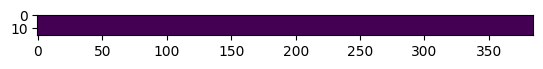

In [18]:
# solid color --> no padding tokens
plt.imshow(query_response_padding_masks.cpu());

#### Create attention masks and position IDs for any padding tokens in inputs

In [51]:
# Used to mask the scores after the query-key multiplication and before the softmax. 
# This parameter is required during inference if caches have been setup.
# A value of True in row ``i`` and column ``j`` means token ``i`` attends to token ``j``.
masks = generation.get_causal_mask_from_padding_mask(
    query_response_padding_masks
)

# Contains the position ids of each token. 
# This parameter is required during inference if caches have been setup.
# During training, this is used to indicate the positions of each token relative to its sample.
# During inference, this indicates the position of the current token.
position_ids = generation.get_position_ids_from_padding_mask(
    query_response_padding_masks
)
del query_response_padding_masks

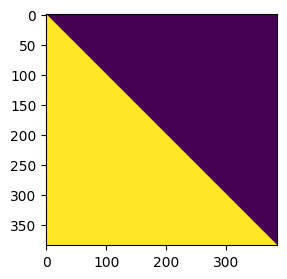

In [52]:
# Perfect triangle means token at current step can only see tokens earlier in the autoregression sequence. 
plt.figure(figsize=(3,3))
plt.imshow(masks[0].cpu());

#### Compute the logits in a `forward` pass

In [53]:
logits = self._model(query_responses, input_pos=position_ids, mask=masks)
ref_logits = self._ref_model(query_responses, input_pos=position_ids, mask=masks)

In [54]:
assert logits.shape[0] == grpo_size, 'The model forward pass is not making the correct number of GRPO samples.'
assert logits.shape[1] <= self._max_generated_tokens, 'The model forward pass is not respecting max_generated_tokens.'
assert logits.shape[2] == self._tokenizer.vocab_size - 1, 'The model forward pass is not respecting the vocab size.'

assert ref_logits.shape[0] == grpo_size, 'The ref model forward pass is not making the correct number of GRPO samples.'
assert ref_logits.shape[1] <= self._max_generated_tokens, 'The ref model forward pass is not respecting max_generated_tokens.'
assert ref_logits.shape[2] == self._tokenizer.vocab_size - 1, 'The ref model forward pass is not respecting the vocab size.'
 
assert logits.shape == ref_logits.shape

#### Estimate logprobs of the response using the current and reference policies

In [55]:
logits = logits[:, context_length - 1 :]
logprobs = rlhf.batched_logits_to_logprobs(logits, responses, self._temperature)
del logits
torch.cuda.empty_cache()
ref_logits = self._ref_model(
    query_responses, input_pos=position_ids, mask=masks
)
ref_logits = rlhf.truncate_sequence_for_logprobs(ref_logits, context_length)
ref_logprobs = rlhf.batched_logits_to_logprobs(
    ref_logits, responses, self._temperature
)
del ref_logits
torch.cuda.empty_cache()

In [56]:
assert logprobs.shape == ref_logprobs.shape

In [57]:
# replace any tokens in the responses after the first stop token (usually EOS token) with padding
# resulting in truncated responses
(
    response_padding_masks,
    responses,
) = rlhf.truncate_sequence_at_first_stop_token(  # [B x G, L]
    responses, self._stop_token_ids, self._tokenizer.pad_id
)

responses = responses.reshape(batch_size, grpo_size, -1)  # [B, G, L]

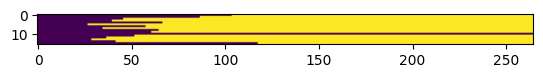

In [59]:
# NOTE: compare to query_response_padding_masks above.
plt.imshow(response_padding_masks.cpu())

In [58]:
print()
for i in range(grpo_size):
    decoded = self._tokenizer.decode(responses[:, i, :].tolist()[0])
    print(decoded)
    break


He earns 12/60=$0.2/hour
So, he earns 0.2 * 50 = $<<0.2*50=10>>10 in an hour
So, he earns 10 * 2 = $<<10*2=20>>20
An hour.
So, he earns 20 * 60 = $<<20*60=1200>>1200 for babysitting for 6 hours.
</think> <answer>1200</answer>


### Computing rewards and successes

Since the reward is obviously the interesting part here, lets implement it inline.
Note that this is a signficant deviation from how rewards are being computed in the current `/dev` implementation.
RL nerd-sniped me.

In [60]:
### Copied & slightly refactored from torchtune.dev.grpo.rewards import batch_shaped_correctness_reward.
### Key changes
# 1. Seperate reward function definition from reward batch processing logic.
# 2. Slightly modified XML tag parsing.
# 3. Reduce potential for false negative from formatting differences.
# 4. Explicitly reward step-by-step reasoning.
# 5. Option to return rewards with breakdown by component.

from xml.etree import ElementTree as ET
from typing import Callable, Dict, List, Optional, Tuple, Union, Any
import re
import torch
from dataclasses import dataclass, field
from torchtune.modules.transforms.tokenizers import ModelTokenizer


def extract_tags(text: str) -> dict[str, list[str]]:
    """
    Parse XML-like tags from text. Returns a dictionary with keys 'think' and 'answer'.
    The values are lists of strings, with each string being the content of a tag.
    """
    cleaned_text = text.replace("<<", "").replace(">>", "")
    cleaned_text = re.sub(r'<\s*(\/?)\s*(think|answer)\s*>', r'<\1\2>', cleaned_text)
    xml_string = f"<root>{cleaned_text}</root>"

    try:
        root = ET.fromstring(xml_string)
        return {
            "think": [
                elem.text if elem.text is not None else "" for elem in root.findall("think")
            ],
            "answer": [
                elem.text if elem.text is not None else ""
                for elem in root.findall("answer")
            ],
        }
    except ET.ParseError:
        # Fall back to regex-based extraction if XML parsing fails
        think_tags = re.findall(r'<think>(.*?)</think>', cleaned_text, re.DOTALL)
        answer_tags = re.findall(r'<answer>(.*?)</answer>', cleaned_text, re.DOTALL)
        return {
            "think": think_tags,
            "answer": answer_tags
        }

def normalize_answer(answer: str) -> str:
    """
    Normalize answer string to handle common variations.
    - Remove currency symbols, commas, and extra whitespace
    - Standardize number format
    """
    # Remove currency symbols, commas in numbers, and normalize whitespace
    normalized = re.sub(r'[\$,\s]', '', answer)
    
    # Try to extract numbers if the answer is primarily numeric
    number_match = re.search(r'[-+]?\d*\.?\d+', normalized)
    if number_match and len(number_match.group()) > len(normalized) * 0.5:
        return number_match.group()
    
    return normalized.strip().lower()


@dataclass
class RewardComponentInfo:
    """Metadata for a reward component."""
    name: str
    description: str
    max_value: float
    weight: float = 1.0
    is_critical: bool = False


@dataclass
class RewardResult:
    """Result of evaluating a reward function."""
    raw_score: float
    weighted_score: float
    max_possible: float
    is_fully_satisfied: bool = False
    info: Dict[str, Any] = field(default_factory=dict)


class RewardComponent:
    """Base class for reward components."""

    def __init__(self, info: RewardComponentInfo):
        self.info = info 
    
    def evaluate(self, context: Dict[str, Any], debug:bool=False) -> RewardResult:
        raise NotImplementedError()


class FormatComponent(RewardComponent):
    """Reward proper formatting with <think> and <answer> tags."""

    def evaluate(self, context: Dict[str, Any]) -> RewardResult:
        tags = context['tags']
        score = 0.0
        info = {}
        if len(tags["answer"]) == 1: 
            answer_score = self.info.max_value / 2
            info["answer_tag"] = "perfect"
        elif len(tags["answer"]) > 1:
            answer_score = self.info.max_value / 5 # some credit for having multiple <answer> tags.
            info["answer_tag"] = "multiple"
        else:
            answer_score = 0.0
            info["answer_tag"] = "missing"
        if len(tags["think"]) == 1:
            think_score = self.info.max_value / 2
            info["think_tag"] = "perfect"
        elif len(tags["think"]) > 0:
            think_score = self.info.max_value / 5
            info["think_tag"] = "multiple"
        else:
            think_score = 0.0
            info["think_tag"] = "missing"

        score = answer_score + think_score
        fully_satistifed = len(tags["answer"]) == 1 and len(tags["think"]) == 1

        return RewardResult(
            raw_score=score,
            weighted_score=score * self.info.weight,
            max_possible=self.info.max_value * self.info.weight,
            is_fully_satisfied=fully_satistifed,
            info=info
        )
    
class ExactAnswerComponent(RewardComponent):
    """Reward component for exact answer match."""
    
    def evaluate(self, context: Dict[str, Any]) -> RewardResult:
        tags = context['tags']
        normalized_ground_truth = context['normalized_ground_truth']
        
        normalized_answers = [normalize_answer(a) for a in tags["answer"]]
        
        # Check for exact match
        exact_match = normalized_ground_truth in normalized_answers
        
        score = self.info.max_value if exact_match else 0.0

        info = {
            "exact_match": exact_match,
            "normalized_answers": normalized_answers,
            "normalized_ground_truth": normalized_ground_truth
        }
        
        return RewardResult(
            raw_score=score,
            weighted_score=score * self.info.weight,
            max_possible=self.info.max_value * self.info.weight,
            is_fully_satisfied=exact_match,
            info=info
        )


class SubstringAnswerComponent(RewardComponent):
    """Reward component for substring match in answer."""
    
    def evaluate(self, context: Dict[str, Any]) -> RewardResult:
        tags = context['tags']
        normalized_ground_truth = context['normalized_ground_truth']
        
        normalized_answers = [normalize_answer(a) for a in tags["answer"]]
        
        # Check for substring match
        substring_match = any(normalized_ground_truth in norm_ans for norm_ans in normalized_answers)
        
        score = self.info.max_value if substring_match else 0.0

        info = {
            "substring_match": substring_match,
            "normalized_answers": normalized_answers,
            "normalized_ground_truth": normalized_ground_truth
        }
        
        return RewardResult(
            raw_score=score,
            weighted_score=score * self.info.weight,
            max_possible=self.info.max_value * self.info.weight,
            is_fully_satisfied=substring_match,
            info=info
        )


class ReasoningQualityComponent(RewardComponent):
    """Reward component for evaluating quality of reasoning."""
    
    def evaluate(self, context: Dict[str, Any]) -> RewardResult:
        tags = context['tags']
        answer = context['answer']
        
        if not tags["think"]:
            return RewardResult(
                raw_score=0.0,
                weighted_score=0.0,
                max_possible=self.info.max_value * self.info.weight,
                is_fully_satisfied=False,
                info={"reasoning": "missing"}
            )
        
        thinking = tags["think"][0]
        score = 0.0
        info = {}
        
        # Reward for having calculation steps (numbers and operators)
        calc_pattern = r'\d+\s*[\+\-\*\/]\s*\d+'
        calculations = re.findall(calc_pattern, thinking)
        calc_score = min(len(calculations), 5) * (self.info.max_value / 10)  # Up to half points for calculations
        info["calculations"] = len(calculations)
        
        # Check if final calculation leads to answer
        normalized_answer = normalize_answer(answer)
        answer_in_reasoning = normalized_answer in thinking
        if answer_in_reasoning:
            answer_score = 3.0 * (self.info.max_value / 10)  # 30% of max for answer in reasoning
        else:
            answer_score = 0.0
        info["answer_in_reasoning"] = answer_in_reasoning
        
        # Check for logical progression (consistent step-by-step approach)
        step_pattern = re.search(r'(first|1st|step 1|begin|start).*?(then|next|2nd|step 2)', 
                              thinking, re.IGNORECASE|re.DOTALL)
        if step_pattern:
            step_score = 2.0 * (self.info.max_value / 10)  # 20% of max for step-by-step reasoning
            info["step_reasoning"] = True
        else:
            step_score = 0.0
            info["step_reasoning"] = False
            
        score = calc_score + answer_score + step_score
        fully_satisfied = score >= self.info.max_value * 0.8
        
        return RewardResult(
            raw_score=score,
            weighted_score=score * self.info.weight,
            max_possible=self.info.max_value * self.info.weight,
            is_fully_satisfied=fully_satisfied,
            info=info
        )


class CorrectFinalAnswerComponent(RewardComponent):
    """Critical component that gives full reward if final answer is correct."""
    
    def evaluate(self, context: Dict[str, Any]) -> RewardResult:
        tags = context['tags']
        normalized_ground_truth = context['normalized_ground_truth']
        
        if not tags["answer"]:
            return RewardResult(
                raw_score=0.0,
                weighted_score=0.0,
                max_possible=self.info.max_value * self.info.weight,
                is_fully_satisfied=False,
                info={"final_answer": "missing"}
            )
        
        final_answer = normalize_answer(tags["answer"][-1])
        correct_final_answer = final_answer == normalized_ground_truth
        
        score = self.info.max_value if correct_final_answer else 0.0
        info = {
            "correct_final_answer": correct_final_answer,
            "final_answer": final_answer,
            "normalized_ground_truth": normalized_ground_truth
        }
        
        return RewardResult(
            raw_score=score,
            weighted_score=score * self.info.weight,
            max_possible=self.info.max_value * self.info.weight,
            is_fully_satisfied=correct_final_answer,
            info=info
        )


class RewardFunction:
    """
    Aggregates multiple reward components and evaluates completions.
    """
    
    def __init__(self, components: List[RewardComponent] = None):
        self.components = components or []
        self._setup_default_components()
    
    def _setup_default_components(self):
        """Set up the default reward components if none provided."""
        if not self.components:
            self.components = [
                FormatComponent(
                    RewardComponentInfo(
                        name="format",
                        description="Proper format with single think and answer tags",
                        max_value=10.0,
                        weight=1.0
                    )
                ),
                ExactAnswerComponent(
                    RewardComponentInfo(
                        name="exact_answer",
                        description="Exact match of answer in any answer tag",
                        max_value=20.0,
                        weight=1.0
                    )
                ),
                SubstringAnswerComponent(
                    RewardComponentInfo(
                        name="substring_answer",
                        description="Substring match of answer in any answer tag",
                        max_value=10.0,
                        weight=1.0
                    )
                ),
                ReasoningQualityComponent(
                    RewardComponentInfo(
                        name="reasoning",
                        description="Quality of reasoning in think tag",
                        max_value=10.0,
                        weight=0.6
                    )
                ),
                CorrectFinalAnswerComponent(
                    RewardComponentInfo(
                        name="correct_final_answer",
                        description="Correct answer in final answer tag",
                        max_value=100.0,
                        weight=1.0,
                        is_critical=True
                    )
                )
            ]
    
    def evaluate(
        self, 
        answer: str, 
        completion: str,
        return_details: bool = False
    ) -> Union[Tuple[float, float], Tuple[float, float, Dict[str, Any]]]:
        """
        Evaluate a completion against an answer.
        
        Args:
            answer: The ground truth answer.
            completion: The model's (decoded) completion.
            return_details: Whether to return detailed component scores.
            
        Returns:
            reward: Total reward value.
            success: Binary success indicator (1.0 or 0.0).
            details: (optional) Dictionary of component details.
        """
        
        tags = extract_tags("<think>" + completion)
        normalized_ground_truth = normalize_answer(answer)
        
        context = {
            'answer': answer,
            'completion': completion,
            'tags': tags,
            'normalized_ground_truth': normalized_ground_truth
        }
        
        component_results = {}
        total_reward = 0.0
        success = 0.0
        
        for component in self.components:
            result = component.evaluate(context)
            component_results[component.info.name] = result
            
            total_reward += result.weighted_score
            
            if component.info.is_critical and result.is_fully_satisfied:
                total_reward = 100.0  # Override with full reward
                success = 1.0
        
        if return_details:
            details = {
                'component_results': component_results,
                'total_reward': total_reward,
                'success': success
            }
            return total_reward, success, details
        
        return total_reward, success


def batch_shaped_correctness_reward(
    tokenizer: ModelTokenizer, 
    completions: torch.Tensor, 
    answers: list[str],
    reward_function: Optional[RewardFunction] = None,
    return_details: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Utility function to apply the shaped reward function to a GRPO-style batch of completions."""

    if reward_function is None:
        reward_function = RewardFunction()

    if return_details:
        all_details = []

    batch_size, grpo_size, *_ = completions.shape
    rewards = torch.zeros(batch_size, grpo_size, dtype=torch.float32)
    successes = torch.zeros(batch_size, grpo_size, dtype=torch.float32)
    # completions :: [B, G, L]
    for b in range(batch_size):
        for g in range(grpo_size):
            text_completion = tokenizer.decode(
                completions[b, g].tolist()
            )  # skips special tokens, stops at eos
            if return_details:
                reward, success, details = reward_function.evaluate(
                    answer=answers[b],
                    completion=text_completion,
                    return_details=True
                ) 
                all_details.append(details)
            else:
                reward, success = reward_function.evaluate(
                    answer=answers[b],
                    completion=text_completion
                )
            rewards[b, g] = reward
            successes[b ,g] = success

    if return_details:
        return rewards, successes, all_details
    
    return rewards, successes, None


In [61]:
# Use with default settings
rewards, successes, details = batch_shaped_correctness_reward(
    self._tokenizer, responses, answers, return_details=True
)

In [37]:
rewards[successes == 1].mean().item(), 0. if not rewards.shape[0] > 1 else rewards[successes == 1].std() 
# NOTE: 100, 0 for reward func above.

(100.0, 0.0)

### Computing advantages

In [38]:
rewards = rewards.to(self._device)
successes = successes.to(self._device)

advantages = (rewards - rewards.mean(1, keepdim=True)) / (
    rewards.std(1, keepdim=True) + 1e-4
)
advantages = advantages.reshape(batch_size * grpo_size) # flatten

In [39]:
def display_responses(prompt, responses, tokenizer, grpo_size, advantages=None, rewards=None, successes=None, component_details=None, show_n:int=None):
    """
    Display responses in Jupyter with reward metrics when available.
    
    Args:
        prompt: The tensor of prompt tokens
        responses: The tensor of response tokens
        tokenizer: The tokenizer to decode responses
        grpo_size: Number of responses to print
        advantages: Optional tensor of advantage values [batch_size, grpo_size]. NOTE: current implementation assumes batch_size=1.
        rewards: Optional tensor of reward values [batch_size, grpo_size]. NOTE: current implementation assumes batch_size=1.
        successes: Optional tensor of success indicators [batch_size, grpo_size]
        component_details: Optional list of component-level reward details
    
    Returns:
        str that can be passed to IPython HTML display, embedded in Metaflow card or any other UI, of responses with optional reward metrics.
    """
    import re

    if rewards.shape[0] > 1:
        raise Warning('Rewards dim 0 is > 1, meaning batch_size > 1. This function only displays the first member of the batch.')
    
    html_output = """
        <style>
            .prompt-box {
                margin: 20px 0;
                padding: 15px;
                border: 1px solid #C4C7AC;
                border-radius: 8px;
                background-color: #F0EBE5;
                color: #4A4A67;
                font-family: 'Courier New', monospace;
                font-size: 14px;
                line-height: 1.6;
                white-space: pre-wrap;
                word-wrap: break-word;
            }
            .response-container {
                margin: 20px 0;
                border: 1px solid #C4C7AC;
                border-radius: 8px;
                overflow: hidden;
                box-shadow: 0 2px 5px rgba(0,0,0,0.05);
                font-family: 'Courier New', monospace;
                max-width: 100%;
            }
            .response-header {
                background-color: #F0EBE5;
                padding: 10px 15px;
                font-size: 16px;
                font-weight: bold;
                border-bottom: 1px solid #C4C7AC;
                color: #4A4A67;
                display: flex;
                justify-content: space-between;
                align-items: center;
            }
            .response-body {
                background-color: #ffffff;
                color: #4A4A67;
                padding: 15px;
                white-space: pre-wrap;
                word-wrap: break-word;
                line-height: 1.6;
                font-size: 14px;
            }
            .think-tag {
                color: #BE6A1A;
                font-weight: bold;
            }
            .answer-tag {
                color: #2C6846;
                font-weight: bold;
            }
            .calculation {
                color: #2E5CA7;
                background-color: #E9F0FA;
                padding: 2px 4px;
                border-radius: 2px;
            }
            .math {
                font-family: 'Courier New', monospace;
                background-color: #F0EBE5;
                padding: 0 3px;
                border-radius: 3px;
            }
            .metric-label {
                color: #4A4A67;
            }
            .metrics-container {
                background-color: #F0EBE5;
                border-top: 1px solid #C4C7AC;
                padding: 10px 15px;
            }
            .metric-score {
                font-family: monospace;
                font-weight: bold;
                padding: 2px 8px;
                border-radius: 4px;
                display: inline-block;
                margin-right: 8px;
            }
            .score-high {
                background-color: #D3EFE0;
                color: #177350;
            }
            .score-medium {
                background-color: #FCF1D6;
                color: #BE6A1A;
            }
            .score-low {
                background-color: #FAD9D8;
                color: #C5393A;
            }
            .success-badge {
                background-color: #177350;
                color: white;
                padding: 3px 8px;
                border-radius: 4px;
                font-size: 12px;
                font-weight: bold;
            }
            .failure-badge {
                background-color: #4A4A67;
                color: white;
                padding: 3px 8px;
                border-radius: 4px;
                font-size: 12px;
                font-weight: bold;
            }
            .component-table {
                width: 100%;
                border-collapse: collapse;
                margin-top: 10px;
                font-size: 13px;
            }
            .component-table th {
                background-color: #F0EBE5;
                text-align: left;
                padding: 6px 10px;
                color: #4A4A67;
                font-weight: bold;
            }
            .component-table td {
                border-top: 1px solid #C4C7AC;
                padding: 6px 10px;
                color: #4A4A67;
            }
            .component-progress {
                height: 8px;
                width: 100%;
                background-color: #E5E7D9;
                border-radius: 4px;
                overflow: hidden;
            }
            .component-progress-bar {
                height: 100%;
                background-color: #6B9BD0;
            }
            .metrics-toggle {
                cursor: pointer;
                color: #3F7DC9;
                text-decoration: underline;
                font-size: 12px;
                margin-top: 5px;
                display: inline-block;
                font-weight: bold;
            }
            .details-container {
                display: none;
                margin-top: 10px;
                border-top: 1px solid #C4C7AC;
                padding-top: 10px;
            }
    </style>
    <script>
    function toggleDetails(id) {
        var details = document.getElementById('details-' + id);
        if (details.style.display === 'none' || details.style.display === '') {
            details.style.display = 'block';
        } else {
            details.style.display = 'none';
        }
    }
    </script>
    """
    
    has_rewards = rewards is not None and successes is not None
    has_details = component_details is not None

    ### PROCESS PROMPTS ###
    if hasattr(prompt, 'shape'):
        prompt_decoded = tokenizer.decode(
            prompt[0].tolist() 
            if len(prompt.shape) > 0 and prompt.shape[0] > 0 else prompt.tolist()
        )
    else:
        prompt_decoded = str(prompt)
    
    ### PROCESS RESPONSES ###
    responses_decoded = []
    for i in range(grpo_size):
        try:
            decoded = tokenizer.decode(responses[:, i, :].tolist()[0])
            responses_decoded.append(decoded)
        except:
            responses_decoded.append("Sample response")
    
    if show_n:
        responses_decoded = responses_decoded[:show_n]
    
    ### SHOW PROMPT ###
    formatted_prompt = prompt_decoded.replace("<", "&lt;").replace(">", "&gt;")
    formatted_prompt = formatted_prompt.replace("\n", "<br>")
    html_output += f'<div class="prompt-box"><div style="background-color: #F0EBE5; font-size: 16px; font-weight: bold;">Prompt</div>{formatted_prompt}</div>'

    for i, response in enumerate(responses_decoded):
        html_output += f'<div class="response-container">'
        ### START HEADER ###
        html_output += f'<div class="response-header">'
        html_output += f'<div>Response #{i+1}</div>'
        if has_rewards:
            reward = rewards[0][i].item()  # Assuming batch_size=1 for simplicity
            success = successes[0][i].item()
            if success > 0.5:
                html_output += f'<div class="success-badge">SUCCESS</div>'
            else:
                html_output += f'<div class="failure-badge">FAIL</div>'
        html_output += '</div>'
        ### START RESPONSE BODY ### 
        html_output += f'<div class="response-body">'
        response = response.replace("\n", "<br>")
        # Escape HTML tags but keep <br> tags.
        response = response.replace("<", "&lt;").replace(">", "&gt;")
        response = response.replace("&lt;br&gt;", "<br>")
        ### HIGHLIGHT THINK TAGS ###
        response = re.sub(
            r'&lt;/think&gt;', 
            '<span class="think-tag">&lt;/think&gt;</span>', 
            response
        )
        response = re.sub(
            r'&lt;think&gt;', 
            '<span class="think-tag">&lt;think&gt;</span>', 
            response
        )
        ### HIGHLIGHT ANSWER TAG ###
        response = re.sub(
            r'&lt;/answer&gt;', 
            '<span class="answer-tag">&lt;/answer&gt;</span>', 
            response
        )
        response = re.sub(
            r'&lt;answer&gt;', 
            '<span class="answer-tag">&lt;answer&gt;</span>', 
            response
        )
        # HIGHLIGHT CALCULATIONS with $<<...>>$ pattern ###
        response = re.sub(
            r'\$&lt;&lt;(.+?)&gt;&gt;\$', 
            r'<span class="calculation">$&lt;&lt;\1&gt;&gt;$</span>', 
            response
        )
        ### FORMAT MATH EXPRESSIONS ###
        response = re.sub(
            r'(\d+[*/+-]\d+(?:[*/+-]\d+)*)', 
            r'<span class="math">\1</span>', 
            response
        )
        html_output += response
        html_output += '</div>' 
        ### START METRICS ###
        if has_rewards:
            html_output += f'<div class="metrics-container">'
            reward = rewards[0][i].item()  # Assuming batch_size=1
            advantage = advantages[i].item()
            score_class = "score-high" if reward >= 80 else "score-medium" if reward >= 30 else "score-low"
            html_output += f'<div><strong class="metric-label">Reward:</strong> <span class="metric-score {score_class}">{reward:.1f}</span></div>'
            html_output += f'<div><strong class="metric-label">Advantage:</strong> <span class="metric-score {score_class}">{advantage:.1f}</span></div>'
            if has_details and i < len(component_details):
                details = component_details[i]
                html_output += f'<a class="metrics-toggle" onclick="toggleDetails({i})">Show component details</a>'
                html_output += f'<div id="details-{i}" class="details-container">'
                ### TABLE OF COMPONENTS ###
                html_output += '<table class="component-table">'
                html_output += '<tr><th>Component</th><th>Score</th><th>Weight</th><th>Contribution</th></tr>'
                for comp_name, result in details['component_results'].items():
                    raw_score = result.raw_score
                    weighted_score = result.weighted_score
                    max_possible = result.max_possible
                    is_satisfied = result.is_fully_satisfied
                    # For progress bar.
                    percentage = (weighted_score / max_possible) * 100 if max_possible > 0 else 0
                    # Format row in table. Another SO to Claude.
                    status_color = "#2b8a3e" if is_satisfied else "#e67700"
                    html_output += f'<tr>'
                    html_output += f'<td style="color: {status_color}; font-weight: {("bold" if is_satisfied else "normal")}">{comp_name}</td>'
                    max_raw = max_possible/result.weighted_score*raw_score if raw_score > 0 and result.weighted_score > 0 else max_possible
                    html_output += f'<td>{raw_score:.1f} / {max_raw:.1f}</td>'
                    html_output += f'<td>{result.weighted_score/raw_score if raw_score > 0 else 0:.1f}x</td>'
                    html_output += f'<td>'
                    html_output += f'<div class="component-progress">'
                    html_output += f'<div class="component-progress-bar" style="width: {min(percentage, 100)}%; background-color: {status_color if is_satisfied else "#4dabf7"};"></div>'
                    html_output += f'</div>'
                    html_output += f'</td>'
                    html_output += f'</tr>'
                html_output += '</table>'
                # Show component by component 
                for comp_name, result in details['component_results'].items():
                    if hasattr(result, 'debug_info') and result.debug_info:
                        html_output += f'<div style="margin-top: 8px; font-size: 12px; color: #495057;">'
                        html_output += f'<strong>{comp_name} details:</strong> '            
                        # Format debug info
                        debug_parts = []
                        for key, value in result.debug_info.items():
                            if isinstance(value, bool):
                                icon = "✓" if value else "✗"
                                color = "#2b8a3e" if value else "#c92a2a"
                                debug_parts.append(f'<span style="color: {color}">{key}: {icon}</span>')
                            else:
                                debug_parts.append(f'{key}: {value}')
                        html_output += ', '.join(debug_parts)
                        html_output += '</div>'
                html_output += '</div>'  # Close details container
            html_output += '</div>'  # Close metrics container
        html_output += '</div>'  # Close response container
    
    return html_output

In [40]:
display(HTML(display_responses(
    prompt=batch_input_ids, # NOTE: assume all prompts within batch are the same
    responses=responses,
    tokenizer=self._tokenizer,
    grpo_size=self.grpo_samples,
    advantages=advantages,
    rewards=rewards,
    successes=successes,
    component_details=details,
    show_n=4
)))

Component,Score,Weight,Contribution
format,10.0 / 10.0,1.0x,
exact_answer,0.0 / 20.0,0.0x,
substring_answer,0.0 / 10.0,0.0x,
reasoning,8.0 / 10.0,0.6x,
correct_final_answer,0.0 / 100.0,0.0x,
Component,Score,Weight,Contribution
format,10.0 / 10.0,1.0x,
exact_answer,0.0 / 20.0,0.0x,
substring_answer,0.0 / 10.0,0.0x,
reasoning,5.0 / 10.0,0.6x,


In [106]:
del responses
torch.cuda.empty_cache()

seq_lens = training.get_unmasked_sequence_lengths(response_padding_masks)

### Mask out all the invalid values in the trajectory due to padding tokens
logprobs[response_padding_masks] = 1.0
ref_logprobs[response_padding_masks] = 1.0

In [107]:
trajectories = [
    GRPOTrajectory(
        query_responses=query_responses,
        logprobs=logprobs,
        ref_logprobs=ref_logprobs,
        rewards=rewards.reshape(batch_size * grpo_size),
        successes=successes.reshape(batch_size * grpo_size),
        advantages=advantages,
        masks=masks,
        position_ids=position_ids,
        response_padding_masks=response_padding_masks,
        seq_lens=seq_lens,
    )
]

In [108]:
trajectory = GRPOTrajectory(*map(torch.cat, zip(*trajectories)))

In [109]:
torch.distributed.barrier()

### PPO epoch

In [ ]:
grpo_stats = []

for _ in range(self._ppo_epochs):
    # step_stats = self.grpo_step(trajectory, context_length)
    ...

#### Unrolling `self.grpo_step`

In [ ]:
trajectory.query_responses.shape # [grpo_size, n_tokens_generated]

In [ ]:
n = random.randint(0, trajectory.query_responses.shape[0]-1)
pprint(self._tokenizer.decode(trajectory.query_responses[n].reshape(-1).tolist()))
print('-'*80)
pprint(self._tokenizer.decode(trajectory.query_responses[:, context_length:][n].reshape(-1).tolist()))

In [112]:
torch.cuda.empty_cache()
pi_logits = self._model(
    trajectory.query_responses,
    input_pos=trajectory.position_ids,
    mask=trajectory.masks,
) 

In [113]:
prior_response_dim = pi_logits.shape[1] # pi_logits is tensor of shape [grpo_size, context_length + response_length, vocab_size]

In [114]:
pi_logits = rlhf.truncate_sequence_for_logprobs(pi_logits, context_length)

In [115]:
assert prior_response_dim - context_length == pi_logits.shape[1], 'rlhf.truncate_sequence_for_logprobs is not producing right context window.'

In [116]:
pi_logprobs = rlhf.batched_logits_to_logprobs(
    pi_logits,
    trajectory.query_responses[:, context_length:],
    self._temperature,
    chunk_size=1,
) # The log probabilities corresponding to each token in the generated sequence part of trajectory.query_responses.

In [ ]:
pi_logprobs.shape

#### Loss function! 

In [ ]:
del pi_logits
torch.cuda.empty_cache()

In [119]:
from typing import Optional, Tuple

import torch
import torch.nn as nn
from torchtune import rlhf
from torchtune.rlhf import masked_sum


class GRPOLoss(nn.Module):
    """
    Group Relative Policy Optimization (GRPO) Loss module.
    Introduced by https://arxiv.org/abs/2402.03300, popularized by https://arxiv.org/abs/2501.12948.

    This loss implementation follows the usual formulation of GRPO with clipped ratios of token-wise logprobs.
    Currently not validated to perform well.

    Args:
        epsilon (float): clipping range for GRPO update.
        kl_coeff (float): KL divergence coefficient (also known as beta).
    """

    def __init__(
        self,
        epsilon: float = 0.1,
        kl_coeff: float = 0.1,
    ):
        super().__init__()
        self.epsilon = epsilon
        self.kl_coeff = kl_coeff

    def forward(
        self,
        pi_old_logprobs: torch.Tensor,  # [B x G, L]
        pi_logprobs: torch.Tensor,  # [B x G, L]
        ref_logprobs: torch.Tensor,  # [B x G, L]
        advantages: torch.Tensor,  # [B x G]
        padding_masks: Optional[torch.Tensor] = None,  # [B x G, L]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the GRPO loss module.

        Args:
            pi_old_logprobs (torch.Tensor): Log probabilities of the old policy. Shape: [batch_size * num_groups, seq_len]
            pi_logprobs (torch.Tensor): Log probabilities of the current policy. Shape: [batch_size * num_groups, seq_len]
            ref_logprobs (torch.Tensor): Log probabilities of the reference model. Shape: [batch_size * num_groups, seq_len]
            advantages (torch.Tensor): Advantage values. Shape: [batch_size * num_groups]
            padding_masks (Optional[torch.Tensor]): Padding token masks where True indicates tokens to include in loss calculation.
                Shape: [batch_size * num_groups, seq_len]

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
                - loss: Total GRPO loss (policy loss + KL penalty)
                - policy_loss: Clipped policy loss
                - kl_loss: KL divergence loss between policy and reference model
                - ratios: Mean ratio between current and old policy probabilities
                - clipfrac: Fraction of clipped policy ratios
        """

        ratios = torch.exp(pi_logprobs - pi_old_logprobs)  # [B x G, L]
        clipped_ratios = torch.clamp(
            ratios, 1.0 - self.epsilon, 1.0 + self.epsilon
        )  # [B x G, L]

        advantages = advantages[:, None]  # [B x G, 1]

        policy_losses_clipped = advantages * clipped_ratios  # [B x G, L]
        policy_losses_unclipped = advantages * ratios  # [B x G, L]

        clipfrac = (
            policy_losses_clipped < policy_losses_unclipped
        ).float()  # [B x G, L]
        clipfrac = rlhf.masked_mean(clipfrac, padding_masks)  # scalar

        policy_loss = torch.minimum(
            policy_losses_clipped, policy_losses_unclipped
        )  # [B x G, L]
        policy_loss = rlhf.masked_mean(policy_loss, padding_masks)

        kl_loss = (
            torch.exp(ref_logprobs - pi_logprobs) - (ref_logprobs - pi_logprobs) - 1
        )  # [B x G]
        kl_loss = rlhf.masked_mean(kl_loss, padding_masks)

        loss = -(policy_loss - self.kl_coeff * kl_loss)

        return (
            loss,
            policy_loss.detach(),
            kl_loss.detach(),
            ratios.mean().detach(),
            clipfrac.detach(),
        )


class GRPOCompletionLoss(nn.Module):
    """
    Group Relative Policy Optimization (GRPO) Loss module.
    Introduced by https://arxiv.org/abs/2402.03300, popularized by https://arxiv.org/abs/2501.12948.

    This loss implementation follows the usual formulation of GRPO with clipped ratios of full completion logprobs.
    Currently not validated to perform well.

    Args:
        epsilon (float): clipping range for GRPO update.
        kl_coeff (float): KL divergence coefficient (also known as beta).
    """

    def __init__(
        self,
        epsilon: float = 0.1,
        kl_coeff: float = 0.1,
    ):
        super().__init__()
        self.epsilon = epsilon
        self.kl_coeff = kl_coeff

    def forward(
        self,
        pi_old_logprobs: torch.Tensor,  # [B x G, L]
        pi_logprobs: torch.Tensor,  # [B x G, L]
        ref_logprobs: torch.Tensor,  # [B x G, L]
        advantages: torch.Tensor,  # [B x G]
        padding_masks: Optional[torch.Tensor] = None,  # [B x G, L]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the GRPO loss module.

        Args:
            pi_old_logprobs (torch.Tensor): Log probabilities of the old policy. Shape: [batch_size * num_groups, seq_len]
            pi_logprobs (torch.Tensor): Log probabilities of the current policy. Shape: [batch_size * num_groups, seq_len]
            ref_logprobs (torch.Tensor): Log probabilities of the reference model. Shape: [batch_size * num_groups, seq_len]
            advantages (torch.Tensor): Advantage values. Shape: [batch_size * num_groups]
            padding_masks (Optional[torch.Tensor]): Padding token masks where True indicates tokens to include in loss calculation.
                Shape: [batch_size * num_groups, seq_len]

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
                - loss: Total GRPO loss (policy loss + KL penalty)
                - policy_loss: Clipped policy loss
                - kl_loss: KL divergence loss between policy and reference model
                - ratios: Mean ratio between current and old policy probabilities
                - clipfrac: Fraction of clipped policy ratios
        """

        pi_old_logprobs = masked_sum(pi_old_logprobs, padding_masks)  # [B x G]
        pi_logprobs = masked_sum(pi_logprobs, padding_masks)  # [B x G]
        ref_logprobs = masked_sum(ref_logprobs, padding_masks)  # [B x G]

        ratios = torch.exp(pi_logprobs - pi_old_logprobs)  # [B x G]
        clipped_ratios = torch.clamp(
            ratios, 1.0 - self.epsilon, 1.0 + self.epsilon
        )  # [B x G]

        policy_losses_clipped = advantages * clipped_ratios  # [B x G]
        policy_losses_unclipped = advantages * ratios  # [B x G]

        clipfrac = (policy_losses_clipped < policy_losses_unclipped).float()  # [B x G]
        clipfrac = clipfrac.mean()  # scalar, only for logging

        policy_loss = torch.minimum(
            policy_losses_clipped, policy_losses_unclipped
        )  # [B x G]
        policy_loss = policy_loss.mean()  # scalar

        kl_loss = (
            torch.exp(ref_logprobs - pi_logprobs) - (ref_logprobs - pi_logprobs) - 1
        )  # [B x G]
        kl_loss = rlhf.masked_mean(kl_loss, padding_masks)

        loss = -(policy_loss - self.kl_coeff * kl_loss)

        return (
            loss,
            policy_loss.detach(),
            kl_loss.detach(),
            ratios.mean().detach(),
            clipfrac.detach(),
        )


class GRPOSimpleLoss(nn.Module):
    """
    Group Relative Policy Optimization (GRPO) Loss module.
    Introduced by https://arxiv.org/abs/2402.03300, popularized by https://arxiv.org/abs/2501.12948.

    This loss implementation is based on TRL's implementation of GRPO,
     which only takes a single gradient step per batch, trivializing some parts of the computation.
     This empirically seems to perform well.

    Args:
        epsilon (float): clipping range for GRPO update.
        kl_coeff (float): KL divergence coefficient (also known as beta).
    """

    def __init__(
        self,
        epsilon: float = 0.1,
        kl_coeff: float = 0.1,
    ):
        super().__init__()
        self.epsilon = epsilon
        self.kl_coeff = kl_coeff

    def forward(
        self,
        pi_old_logprobs: torch.Tensor,  # [B x G, L]
        pi_logprobs: torch.Tensor,  # [B x G, L]
        ref_logprobs: torch.Tensor,  # [B x G, L]
        advantages: torch.Tensor,  # [B x G]
        padding_masks: Optional[torch.Tensor] = None,  # [B x G, L]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the GRPO loss module.

        Args:
            pi_old_logprobs (torch.Tensor): *UNUSED* Log probabilities of the old policy.
                Shape: [batch_size * num_groups, seq_len]
            pi_logprobs (torch.Tensor): Log probabilities of the current policy.
                Shape: [batch_size * num_groups, seq_len]
            ref_logprobs (torch.Tensor): *UNUSED* Log probabilities of the reference model.
                Shape: [batch_size * num_groups, seq_len]
            advantages (torch.Tensor): Advantage values.
                Shape: [batch_size * num_groups]
            padding_masks (Optional[torch.Tensor]): Padding token masks where True indicates tokens to include in loss calculation.
                Shape: [batch_size * num_groups, seq_len]

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
                - loss: Total GRPO loss (policy loss + KL penalty)
                - policy_loss: Clipped policy loss
                - kl_loss: KL divergence loss between policy and reference model
                - ratios: Mean ratio between current and old policy probabilities
                - clipfrac: Fraction of clipped policy ratios
        """

        # [B x G, L]
        per_token_kl = (
            torch.exp(ref_logprobs.detach() - pi_logprobs)
            - (ref_logprobs.detach() - pi_logprobs)
            - 1
        )

        advantages = advantages[:, None]  # [B x G, 1]

        per_token_policy_loss = (
            torch.exp(pi_logprobs - pi_logprobs.detach()) * advantages
        )

        per_token_loss = -(per_token_policy_loss - self.kl_coeff * per_token_kl)

        loss = rlhf.masked_mean(per_token_loss, padding_masks, dim=1).mean()

        policy_loss = (
            rlhf.masked_mean(per_token_policy_loss, padding_masks, dim=1)
            .mean()
            .detach()
        )
        kl_loss = rlhf.masked_mean(per_token_kl, padding_masks, dim=1).mean().detach()

        return (  # This loss doesn't track clipfrac and ratios
            loss,
            policy_loss,
            kl_loss,
            torch.tensor(1.0),
            torch.tensor(0.0),
        )

In [ ]:
loss_fn = GRPOSimpleLoss(kl_coeff = 0.01, epsilon = 0.2)
loss, policy_loss, kl_loss, ratios, clipfrac = loss_fn(
    trajectory.logprobs,
    pi_logprobs,
    trajectory.ref_logprobs,
    trajectory.advantages,
    padding_masks=~trajectory.response_padding_masks,
)


In [ ]:
loss